<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Interconnect Insights
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Modelo de Predicción de Cancelación de Clientes
</p>

<hr style="border: .4px solid #000000; width: 70%; margin: 10px auto;">  

<p><strong>Interconnect</strong>, un operador líder en telecomunicaciones, busca desarrollar un sistema automatizado para predecir la cancelación de clientes. Esta herramienta permitirá identificar clientes con alta probabilidad de abandonar el servicio y aplicar estrategias de retención, como descuentos y planes personalizados. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.</p>

<p>Servicios de Interconnect:</p>
<ul>
    <li><strong>Comunicación por teléfono fijo</strong>. El teléfono se puede conectar a varias líneas de manera simultánea.</li>
    <li><strong>Internet</strong>. La red se puede configurar a través de una línea telefónica (DSL, <em>línea de abonado digital</em>) o a través de un cable de fibra óptica.</li>
</ul>

<p>Además, brinda servicios adicionales, como:</p>
<ul>
    <li>Seguridad en Internet: <em>ProtecciónDeDispositivo</em> (antivirus) y <em>SeguridadEnLínea</em> (bloqueador de sitios web maliciosos).</li>
    <li>Asistencia técnica: <em>SoporteTécnico</em>.</li>
    <li>Servicios en la nube: <em>BackupOnline</em> (almacenamiento y copias de seguridad).</li>
    <li>Entretenimiento: <em>StreamingTV</em> y <em>StreamingPelículas</em>.</li>
</ul>

<p>Los clientes pueden optar por pagos mensuales o firmar contratos de 1 o 2 años, con diversas opciones de pago y facturación electrónica.</p>


<p><strong>Objetivo del Proyecto</strong></p>

<p>Este proyecto tiene como objetivo desarrollar un modelo predictivo que permita anticipar si un cliente cancelará su contrato con Interconnect. Se trata de un problema de clasificación binaria, donde cada cliente puede clasificarse en una de dos categorías:</p>

- **Sí**: el cliente es propenso a abandonar el servicio.  
- **No**: el cliente probablemente continuará utilizando el servicio.

<p>Para medir el desempeño del modelo, se ha definido como métrica principal el <strong>AUC-ROC</strong>, con un umbral mínimo de <strong>0.85</strong>, lo que asegura una alta capacidad para distinguir entre clientes que se darán de baja y aquellos que permanecerán. Como métrica complementaria se considera la <strong>accuracy</strong>, para ofrecer una visión general del rendimiento del modelo.</p>

<p>La división de los datos será del <strong>80% para entrenamiento</strong>, <strong>10% para validación</strong> y <strong>10% para pruebas</strong>.</p>

<p>Además, se ha incorporado el <strong>F1-score</strong> como una métrica adicional clave, con un umbral mínimo de <strong>0.75</strong>. Esto garantiza un buen equilibrio entre precisión y recuperación, validando que el modelo no solo identifica correctamente a los clientes en riesgo, sino que también reduce al mínimo los falsos positivos y negativos, generando predicciones confiables y accionables. Asimismo, se medirá el tiempo de ejecución de los tres mejores modelos para evaluar su eficiencia computacional.</p>
 
<p><strong>Diccionario de Datos</strong></p>
<p>Los datos han sido recopilados de diferentes fuentes y se presentan en los siguientes archivos:</p>
<ul>
    <li><strong><code>contract.csv</code></strong> – Información sobre los contratos.</li>
    <li><strong><code>personal.csv</code></strong> – Datos personales de los clientes.</li>
    <li><strong><code>internet.csv</code></strong> – Servicios de Internet contratados.</li>
    <li><strong><code>phone.csv</code></strong> – Servicios de telefonía contratados.</li>
</ul>
<p>Cada archivo contiene la columna <strong><code>customerID</code></strong>, que representa un identificador único para cada cliente. La información del contrato es válida a partir del <strong>1 de febrero de 2020</strong>.</p>

# Carga y Preparación de Datos 

In [61]:
# Libraries
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import warnings

# Importing models and tools from sklearn
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Importing advanced models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Importing tools for class balancing and pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Importing tools for date manipulation
from dateutil.relativedelta import relativedelta

# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress warnings related to data validation
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*feature names.*")

In [62]:
# Load the Data
contract = pd.read_csv('final_provider/contract.csv')
internet = pd.read_csv('final_provider/internet.csv')
personal = pd.read_csv('final_provider/personal.csv')
phone = pd.read_csv('final_provider/phone.csv')

In [63]:
# Convert names to snake_case format 
# Cerate function
def to_snake_case(df):
    def convert_column_name(name):
        # Replace uppercase letters with underscores and convert to lowercase
        name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name).lower()
        # Replace spaces with underscores
        name = name.replace(" ", "_")
        return name
    
    df.columns = [convert_column_name(col) for col in df.columns]
    return df

# Apply the function to each DataFrame
contract = to_snake_case(contract)
internet = to_snake_case(internet)
personal = to_snake_case(personal)
phone = to_snake_case(phone)

Dado que la columna **`customer_id`** es la clave común en todos los archivos CSV, será utilizada para unir los datos y crear un solo *DataFrame*, lo cual permitirá un mejor manejo de la información; sin embargo, primero serán revisados los *DataFrames* de forma individual.       
Al revisar los DataFrames se comprobó que los nombres de las columnas no están en el formato adecuado para python, el snake_case y se realizó la conversión de nombres antes de la revisión individual. 

In [64]:
# Define a function to display head and info of a DataFrame
def explore_dataframe(df, name):
    print(f"\n {name} DataFrame: Head")
    display(df.head())
    print(f"\n {name} DataFrame: Info")
    display(df.info())

# Apply the function to each DataFrame
explore_dataframe(contract, 'Contract')
explore_dataframe(internet, 'Internet')
explore_dataframe(personal, 'Personal')
explore_dataframe(phone, 'Phone')


 Contract DataFrame: Head


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



 Contract DataFrame: Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


 Internet DataFrame: Head


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



 Internet DataFrame: Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


 Personal DataFrame: Head


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



 Personal DataFrame: Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


 Phone DataFrame: Head


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



 Phone DataFrame: Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

**Contract DataFrame**
- **Todas las columnas con 7043 filas**.
- `Total_charges` debe convertirse de `object` a `float`.
- Columnas como `End_date` tienen valores tipo `"No"`, de ahí se crea la columna objetivo `left`

**Internet DataFrame**
- **Menor cantidad de registros (5517)**  (es de esperarse que no exitan clientes con contrato de internet).
- Todos los servicios (OnlineSecurity, etc.) son categóricos y consistentes.
- Conviene verificar si `Internet_service = "No"` para imputar servicios asociados.

**Personal DataFrame**
- **Todas las columnas con 7043 filas**.
- Buena codificación para `Senior_citizen` como entero.
- Listo para usarse tras encoding simple.

**Phone DataFrame**
- **Faltan datos (6361 filas)** algunos clientes sin información telefónica.
- Sólo una columna útil, fácil de integrar con merge por `customer_id`.


----
El siguiente paso consiste en **unir los DataFrames** utilizando la columna `customerID` como clave común. 

In [65]:
# Merge the DataFrames using the 'customer_id' column
df = pd.merge(contract, internet, on='customer_id', how='left')
df = pd.merge(df, personal, on='customer_id', how='left')
df = pd.merge(df, phone, on='customer_id', how='left')

# Display info
print("Merged DataFrame Information")
print(df.info())

Merged DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   internet_service   5517 non-null   object 
 9   online_security    5517 non-null   object 
 10  online_backup      5517 non-null   object 
 11  device_protection  5517 non-null   object 
 12  tech_support       5517 non-null   object 
 13  streaming_tv       5517 non-null   object 
 14  streaming_movies   5517 non-null   object 
 15  gender             7043 non-null   object 


In [66]:
display(df.sample(5))  # Display 5 random records

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
5502,3755-JBMNH,2018-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),71.80,1167.8,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,No
831,9650-VBUOG,2016-12-01,No,Two year,No,Credit card (automatic),25.05,963.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
3916,5600-KTXFM,2019-12-01,No,Month-to-month,No,Mailed check,69.95,143.9,Fiber optic,No,No,No,No,No,No,Male,0,Yes,Yes,No
6860,0402-CQAJN,2016-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,No,No,Yes
3843,0812-WUPTB,2019-10-01,2019-11-01 00:00:00,Month-to-month,No,Mailed check,70.85,70.85,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,No


**Primeros Pasos**:  
Se buscarán y tratarán los valores duplicados. La diferencia en las columnas relacionadas con internet sugiere que no todos los usuarios tienen planes de internet. En cuanto a `multiple_lines`, la mayoría tiene más de una línea. Los valores ausentes, de las columnas de `internet ` y `multiple_lines`serán tratados, y se buscarán valores atípicos.

La columna `total_charges` se convertirá a `float64`, y las columnas `begin_date` y `end_date` se convertirán de `object` a `datetime` ya que son fechas.

### **Duplicados**

In [67]:
# Identify duplicate rows in the DataFrame
duplicates = df[df.duplicated()]

# Display the total 
print(f"Total duplicate rows: {duplicates.shape[0]}")

Total duplicate rows: 0


In [68]:
# Count the total number of duplicate customer_id values
duplicate_count = df['customer_id'].duplicated().sum()

# Display the result
print(f"Total duplicate 'customer_id' values: {duplicate_count}")

Total duplicate 'customer_id' values: 0


### Valores Ausentes
Primero, se rellenarán los valores ausentes del `df original de internet` y de la columna `multiple_lines`.

In [69]:
# List of  internet columns with 5517 non-null values
internet_columns = [
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
]

# Print the value_counts of these columns
for column in internet_columns:
    print(f"\nValue counts for column: {column}")
    print(df[column].value_counts())

# Check the value_counts of 'multiple_lines' which has 6361 non-null values
print("\nValue counts for column: multiple_lines")
print(df['multiple_lines'].value_counts())


Value counts for column: internet_service
internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

Value counts for column: online_security
online_security
No     3498
Yes    2019
Name: count, dtype: int64

Value counts for column: online_backup
online_backup
No     3088
Yes    2429
Name: count, dtype: int64

Value counts for column: device_protection
device_protection
No     3095
Yes    2422
Name: count, dtype: int64

Value counts for column: tech_support
tech_support
No     3473
Yes    2044
Name: count, dtype: int64

Value counts for column: streaming_tv
streaming_tv
No     2810
Yes    2707
Name: count, dtype: int64

Value counts for column: streaming_movies
streaming_movies
No     2785
Yes    2732
Name: count, dtype: int64

Value counts for column: multiple_lines
multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64


In [70]:
# Fill NaN in 'internet_service' with 'no' and in other columns with 'No'
columns_to_fill = [
    'internet_service', 'online_security', 'online_backup', 
    'device_protection', 'tech_support', 'streaming_tv', 
    'streaming_movies', 'multiple_lines'
]

# Fill NaN in 'internet_service' with 'no'
df['internet_service'] = df['internet_service'].fillna('no')

# Fill NaN in other columns with 'No'
for column in columns_to_fill[1:]:  # Exclude 'internet_service'
    df[column] = df[column].fillna('No')

# Check the value counts again to make sure NaN has been replaced
for column in columns_to_fill:
    print(f"\nValue counts for column: {column}")
    print(df[column].value_counts())


Value counts for column: internet_service
internet_service
Fiber optic    3096
DSL            2421
no             1526
Name: count, dtype: int64

Value counts for column: online_security
online_security
No     5024
Yes    2019
Name: count, dtype: int64

Value counts for column: online_backup
online_backup
No     4614
Yes    2429
Name: count, dtype: int64

Value counts for column: device_protection
device_protection
No     4621
Yes    2422
Name: count, dtype: int64

Value counts for column: tech_support
tech_support
No     4999
Yes    2044
Name: count, dtype: int64

Value counts for column: streaming_tv
streaming_tv
No     4336
Yes    2707
Name: count, dtype: int64

Value counts for column: streaming_movies
streaming_movies
No     4311
Yes    2732
Name: count, dtype: int64

Value counts for column: multiple_lines
multiple_lines
No     4072
Yes    2971
Name: count, dtype: int64


### Valores Atítpicos

**Se revisan los valores para encontrar atipicos y convertirlo en númericos**

In [71]:
# Categorical columns 
categories = ['type', 'payment_method',  'gender', 'internet_service']

for column in categories:
    print(f"Value counts para la columna: {column}")
    print(df[column].value_counts(dropna=False), "\n")

Value counts para la columna: type
type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64 

Value counts para la columna: payment_method
payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64 

Value counts para la columna: gender
gender
Male      3555
Female    3488
Name: count, dtype: int64 

Value counts para la columna: internet_service
internet_service
Fiber optic    3096
DSL            2421
no             1526
Name: count, dtype: int64 



La columna `type` será renombrada a `contract_type` para que el nombre de la columna sea más claro y descriptivo. Luego, en la columna `contract_type`, los valores de los tipos de contrato serán reemplazados por valores numéricos: `'Month-to-month'` será cambiado a `0`, `'Two year'` a `1`, y `'One year'` a `2`.

In [72]:
# Rename column 'type' to 'contract_type'
df.rename(columns={'type': 'contract_type'}, inplace=True)

# Replace values in 'contract_type' column
df['contract_type'] = df['contract_type'].replace({
    'Month-to-month': 0,
    'Two year': 1,
    'One year': 2
}).infer_objects(copy=False)

La columna `payment_method` será modificada para reemplazar los valores textuales de los métodos de pago por valores numéricos. El valor `'Bank transfer (automatic)'` será reemplazado por `'0'`, `'Credit card (automatic)'` será reemplazado por `'1'`, `'Electronic check'` será reemplazado por `'2'`, y `'Mailed check'` será reemplazado por `'3'`.

In [73]:
# Replace values in 'payment_method' column
df['payment_method'] = df['payment_method'].replace({
    'Bank transfer (automatic)': '0',
    'Credit card (automatic)': '1',
    'Electronic check': '2',
    'Mailed check': '3'
})

Los datos en la columna `gender` serán cambiados asignando números a cada género. El valor `'Male'` será reemplazado por `1`, y el valor `'Female'` será reemplazado por `0`.

In [74]:
# Replace in 'gender' male = 1 amd Female = 0
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0}).infer_objects(copy=False)

Los datos en la columna `internet_service` serán cambiados asignando números a cada tipo de servicio. El valor `'Fiber optic'` será reemplazado por `0`, `'DSL'` será reemplazado por `1`, y `'no'` será reemplazado por `2`.

In [75]:
# Replace values in 'internet_service' column
df['internet_service'] = df['internet_service'].replace({
    'Fiber optic': 0,
    'DSL': 1,
    'no': 2
}).infer_objects(copy=False)


In [76]:
# Verify the changes 
categories = ['contract_type', 'payment_method', 'gender', 'internet_service']

for column in categories:
    print(f"Value counts para la columna: {column}")
    print(df[column].value_counts(dropna=False), "\n")

Value counts para la columna: contract_type
contract_type
0    3875
1    1695
2    1473
Name: count, dtype: int64 

Value counts para la columna: payment_method
payment_method
2    2365
3    1612
0    1544
1    1522
Name: count, dtype: int64 

Value counts para la columna: gender
gender
1    3555
0    3488
Name: count, dtype: int64 

Value counts para la columna: internet_service
internet_service
0    3096
1    2421
2    1526
Name: count, dtype: int64 



### Tipos de datos y nuevas columnas

La mayoría de las columnas serán cambiadas al tipo de datos adecuado. Los valores `'No'` serán reemplazados por `0` y los valores `'Yes'` serán reemplazados por `1`.

In [77]:
# List of columns to modify
columns_to_modify = [
    'paperless_billing', 'online_security', 'online_backup', 'device_protection', 
    'tech_support', 'streaming_tv', 'streaming_movies', 'partner', 'dependents', 'multiple_lines'
]

# Replace 'No' with 0 and 'Yes' with 1 in the specified columns
df[columns_to_modify] = df[columns_to_modify].replace({'No': 0, 'Yes': 1}).infer_objects(copy=False)

In [78]:
# Convert 'begin_date' to datetime first if not already in datetime format
df['begin_date'] = pd.to_datetime(df['begin_date'], errors='coerce')

# Convert 'begin_date' to Year-Month format
df['begin_date'] = df['begin_date'].dt.strftime('%Y-%m')

# Replace 'No' in 'end_date' with NaT
df['end_date'] = df['end_date'].replace('No', pd.NaT)

# Convert 'end_date' to datetime
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Convert 'end_date' to Year-Month format
df['end_date'] = df['end_date'].dt.strftime('%Y-%m')

# Fill NaN values in 'end_date' with 'N/A'
df['end_date'] = df['end_date'].fillna('N/A')

In [79]:
# Replace non-numeric values with NaN
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

# Convert 'total_charges' to float (this will work now that non-numeric values are NaN)
df['total_charges'] = df['total_charges'].astype(float)

In [80]:
# Convert 'payment_method' to int64
df['payment_method'] = df['payment_method'].astype('int64')

**New Columns**

In [81]:
# Create the new 'extra_charges' column
df['extra_charges'] = df['total_charges'] - df['monthly_charges']

# Reorder the columns to place 'extra_charges' right after 'monthly_charges'
cols = df.columns.tolist()
cols.insert(cols.index('total_charges'), cols.pop(cols.index('extra_charges')))
df = df[cols]

In [82]:
# Fill NaN values with 0 in the specified columns
df['extra_charges'] = df['extra_charges'].fillna(0)
df['total_charges'] = df['total_charges'].fillna(0)

# Check if the missing values have been filled
missing_values = df.isnull().sum()
print("Missing values after filling:")
print(missing_values[missing_values > 0])

Missing values after filling:
Series([], dtype: int64)


In [83]:
# Get the minimum and maximum dates for 'begin_date' and 'end_date'
min_begin_date = df['begin_date'].min()
max_begin_date = df['begin_date'].max()

min_end_date = df['end_date'].min()
max_end_date = df['end_date'].max()

# Print the results
print("Min begin_date:", min_begin_date)
print("Max begin_date:", max_begin_date)
print("Min end_date:", min_end_date)
print("Max end_date:", max_end_date)

Min begin_date: 2013-10
Max begin_date: 2020-02
Min end_date: 2019-10
Max end_date: N/A


In [84]:
# Initialize the 'active_months' column
df['active_months'] = None

for row in range(len(df)):
    # Handle the 'N/A' end_date and calculate the duration in months
    if df.loc[row, 'end_date'] == 'N/A':
        # Assuming the end date for active contracts is '2020-01'
        end_date = pd.to_datetime('2020-01')
    else:
        end_date = pd.to_datetime(df.loc[row, 'end_date'])
    
    # Calculate the duration between 'begin_date' and 'end_date'
    begin_date = pd.to_datetime(df.loc[row, 'begin_date'])
    duration = relativedelta(end_date, begin_date)
    
    # Calculate active months
    df.loc[row, 'active_months'] = duration.years * 12 + duration.months

# Convert the 'active_months' to integer type
df['active_months'] = df['active_months'].astype('int')

In [85]:
# Create 'customer_loyalty_group' a categorical column based on the customer's tenure (active months)
df['customer_loyalty_group'] = pd.cut(
    df['active_months'],
    bins=[0, 6, 12, 24, 60],
    labels=['new', 'recent', 'mid_term', 'loyal']
)

# Map the categorical labels to numbers
group_mapping = {
    'new': 0,
    'recent': 1,
    'mid_term': 2,
    'loyal': 3
}

df['customer_loyalty_group'] = df['customer_loyalty_group'].map(group_mapping)

# Replace NaN values with 0 and convert the column to integers
df['customer_loyalty_group'] = df['customer_loyalty_group'].fillna(0).astype(int)

In [86]:
# Create 'num_services' column
# Define the list of service columns
service_cols = ['streaming_tv', 'streaming_movies', 'device_protection', 'online_backup',
                'online_security', 'tech_support', 'multiple_lines']

# Calculate the total number of services each customer is subscribed to
df['num_services'] = df[service_cols].sum(axis=1)

In [87]:
# Create the 'is_alone' column and assign 1 if the customer has no partner and no dependents, otherwise 0
df['is_alone'] = ((df['partner'] == 0) & (df['dependents'] == 0)).astype(int)

In [88]:
# Verify new data types 
df.dtypes

customer_id                object
begin_date                 object
end_date                   object
contract_type               int64
paperless_billing           int64
payment_method              int64
monthly_charges           float64
extra_charges             float64
total_charges             float64
internet_service            int64
online_security             int64
online_backup               int64
device_protection           int64
tech_support                int64
streaming_tv                int64
streaming_movies            int64
gender                      int64
senior_citizen              int64
partner                     int64
dependents                  int64
multiple_lines              int64
active_months               int64
customer_loyalty_group      int64
num_services                int64
is_alone                    int64
dtype: object

Los tipos de datos son correctos, se continuará con el análisis. 

### Estandarización de valores númericos

In [89]:
# Procesar las columnas monthly_charges, total_charges, extra_charges

# Estandarización de las columnas numéricas (monthly_charges, total_charges, extra_charges)
scaler = StandardScaler()
df[['monthly_charges', 'total_charges', 'extra_charges']] = scaler.fit_transform(df[['monthly_charges', 'total_charges', 'extra_charges']])

# Print Results
print(df[['monthly_charges', 'total_charges', 'extra_charges']].head())

   monthly_charges  total_charges  extra_charges
0        -1.160323      -0.992611      -0.985735
1        -0.259629      -0.172165      -0.170214
2        -0.362660      -0.958066      -0.961570
3        -0.746535      -0.193672      -0.185389
4         0.197365      -0.938874      -0.949710


### Creación de la columna objetivo 
Por medio de la columna `end_date` vamos a crear la columna  `target 'left'`. 

In [90]:
# Replace 'N/A' with NaN (Not a Date)
df['end_date'] = df['end_date'].replace('N/A', pd.NaT)

# Create the 'left' column: 0 if NaT (NaN), 1 if it has a date
df['left'] = df['end_date'].apply(lambda x: 1 if pd.notna(x) else 0)

# Verify the result
print(df[['end_date', 'left']].head(3))

  end_date  left
0      NaT     0
1      NaT     0
2  2019-12     1


# Exploratory Data Analysis (EDA)

Iniciamos creando una copia del DataFrame.

In [91]:
# Create a copy of df
df_copy = df.copy()
df_copy.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,extra_charges,total_charges,internet_service,...,gender,senior_citizen,partner,dependents,multiple_lines,active_months,customer_loyalty_group,num_services,is_alone,left
0,7590-VHVEG,2020-01,NaT,0,1,2,-1.160323,-0.985735,-0.992611,1,...,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,2017-04,NaT,2,0,3,-0.259629,-0.170214,-0.172165,1,...,1,0,0,0,0,33,3,2,1,0
2,3668-QPYBK,2019-10,2019-12,0,1,3,-0.362660,-0.961570,-0.958066,1,...,1,0,0,0,0,2,0,2,1,1
3,7795-CFOCW,2016-05,NaT,2,0,0,-0.746535,-0.185389,-0.193672,1,...,1,0,0,0,0,44,3,3,1,0
4,9237-HQITU,2019-09,2019-11,0,1,2,0.197365,-0.949710,-0.938874,0,...,0,0,0,0,0,2,0,0,1,1


### Distribución de Clientes que han Dejado el Servicio

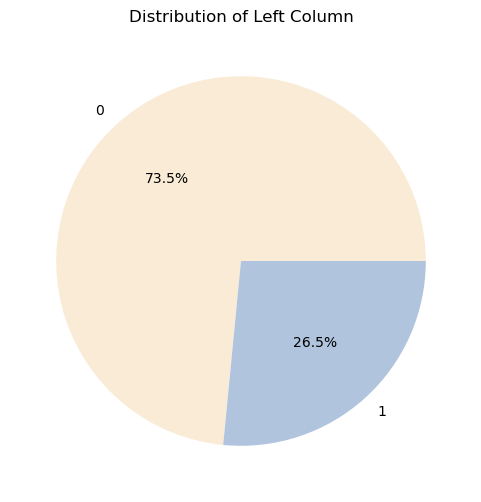

In [92]:
# Count unique values in 'left' column
left_counts = df_copy['left'].value_counts()

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(left_counts, labels=left_counts.index, autopct='%1.1f%%', colors=['antiquewhite', 'lightsteelblue'])
plt.title('Distribution of Left Column')
plt.show()

Hay un **desbalance de clases** que necesita ser corregido.

### Análisis Mensual de Contratos

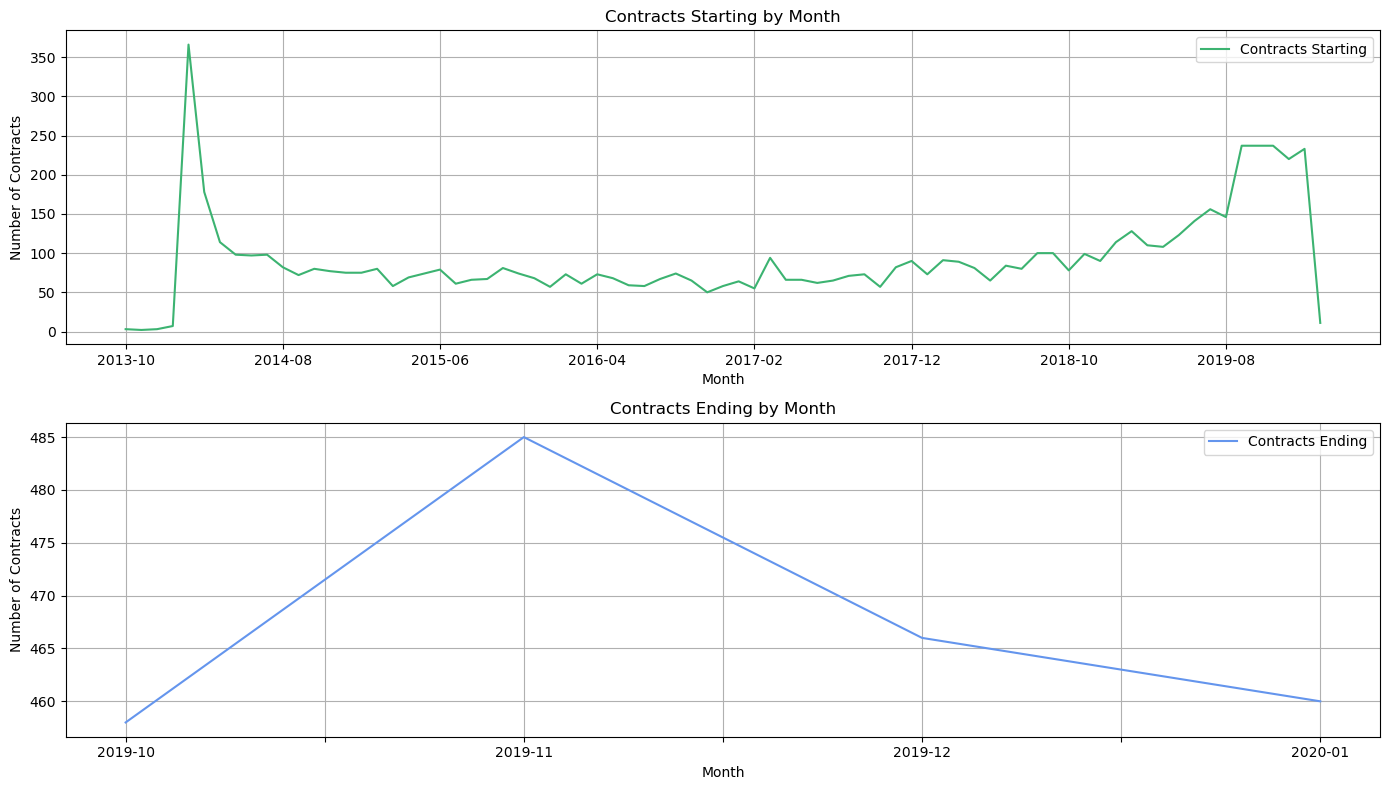

In [93]:
# Group by 'begin_date' and 'end_date' and count the number of occurrences (contracts)
begin_month_count = df_copy.groupby('begin_date').size()
end_month_count = df_copy.groupby('end_date').size()

# Plot the results
plt.figure(figsize=(14, 8))

# Plot contracts starting in each month
plt.subplot(2, 1, 1)
begin_month_count.plot(label='Contracts Starting', color='mediumseagreen')
plt.title('Contracts Starting by Month')
plt.xlabel('Month')
plt.ylabel('Number of Contracts')
plt.legend(loc='upper right')
plt.grid()

# Plot contracts ending in each month
plt.subplot(2, 1, 2)
end_month_count.plot(label='Contracts Ending', color='cornflowerblue')
plt.title('Contracts Ending by Month')
plt.xlabel('Month')
plt.ylabel('Number of Contracts')
plt.legend(loc='upper right')
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Contracts Starting by Month**
   - Muestra un pico extraordinario a inicios de 2014 con aproximadamente 350 contratos
   - Entre 2014-2018, estabilidad con 50-100 contratos mensuales
   - Durante 2019, tendencia creciente hasta alcanzar ~240 contratos
   - Caída abrupta a inicios de 2020

**Contracts Ending by Month**
   - Muestra solo 4 meses (Oct 2019-Ene 2020)
   - Pico en noviembre (~485 contratos finalizados)
   - Descenso constante en diciembre y enero 2020

### Correlación de Variables

In [94]:
# Select the relevant numeric columns
relevant_columns = df_copy[["monthly_charges", "total_charges", "extra_charges", "left"]]

# Calculate the correlation matrix
correlation_matrix = relevant_columns.corr()

# Extract the correlation with the target column 'left' and sort it
correlation_with_target = correlation_matrix["left"].sort_values(ascending=False)

# Display the correlation with the target
print(correlation_with_target)

left               1.000000
monthly_charges    0.193356
total_charges     -0.198324
extra_charges     -0.202655
Name: left, dtype: float64


**Correlación de Cargos con la Cancelación (`left`)**

**Correlaciones Positivas (Mayor riesgo de churn)**

| Variable           | Correlación | Interpretación |
|--------------------|-------------|----------------|
| `monthly_charges`  | **0.193**   | Cuanto más altos son los cargos mensuales, mayor es la probabilidad de que el cliente cancele. Esto puede indicar una sensibilidad al precio. |

---
**Correlaciones Negativas (Menor riesgo de churn)**

| Variable         | Correlación | Interpretación |
|------------------|-------------|----------------|
| `total_charges`  | **-0.198**  | Los clientes con altos cargos acumulados han permanecido más tiempo y, por lo tanto, son más leales. |
| `extra_charges`  | **-0.203**  | Sorprendentemente, quienes pagan cargos adicionales (por servicios extra) tienden a mantenerse, probablemente porque están más comprometidos con el servicio. |
---
**Conclusión Final de Cargos**

- **Clientes con facturas mensuales altas** tienden a cancelar más.
- **Clientes con historial de pagos prolongado o que pagan servicios extra** tienden a quedarse más tiempo, mostrando compromiso y menor sensibilidad al costo.

In [95]:
# Select only boolean columns 
boolean_columns = df_copy.select_dtypes(include=["int64"])

# Calculate the correlation matrix
correlation_matrix = boolean_columns.corr()

# Extract the correlation with the target column 'left' and sort it
correlation_with_target = correlation_matrix["left"].sort_values(ascending=False)

# Display the correlation with the target
print(correlation_with_target)


left                      1.000000
paperless_billing         0.191825
is_alone                  0.162835
senior_citizen            0.150889
payment_method            0.107062
streaming_tv              0.063228
streaming_movies          0.061382
multiple_lines            0.040102
gender                   -0.008612
device_protection        -0.066160
num_services             -0.069533
online_backup            -0.082255
customer_loyalty_group   -0.117592
partner                  -0.150448
dependents               -0.164221
tech_support             -0.164674
online_security          -0.171226
internet_service         -0.316846
active_months            -0.336331
contract_type            -0.341504
Name: left, dtype: float64


**Interpretación de las Correlaciones con la Variable `left` (Cancelación del Cliente)**

**Correlaciones Positivas (Mayor riesgo de churn)**

Estas variables están **positivamente correlacionadas** con la cancelación. Es decir, a medida que su valor aumenta, también lo hace la probabilidad de que el cliente abandone el servicio:

| Variable             | Correlación | Interpretación |
|----------------------|-------------|----------------|
| `paperless_billing`  | **0.192**   | Los clientes con facturación electrónica tienen mayor tendencia a cancelar, posiblemente por ser más digitales e independientes. |
| `is_alone`           | **0.163**   | Los clientes que viven solos muestran mayor probabilidad de churn, quizás por menor necesidad de servicios familiares. |
| `senior_citizen`     | **0.151**   | Los adultos mayores tienden ligeramente más a cancelar, posiblemente por razones económicas o técnicas. |
| `payment_method`     | **0.107**   | Algunos métodos de pago (por ejemplo, automáticos) pueden estar vinculados a una mayor rotación. |
| `streaming_tv`       | **0.063**   | Consumidores de TV en streaming son un poco más propensos a dejar el servicio. |
| `streaming_movies`   | **0.061**   | Similar al punto anterior, el uso de películas en streaming está débilmente relacionado con el abandono. |
| `multiple_lines`     | **0.040**   | Tener múltiples líneas telefónicas está débilmente relacionado con un mayor churn. |

---

**Correlaciones Negativas (Menor riesgo de churn)**

Estas características están **negativamente correlacionadas** con la cancelación. Es decir, su presencia disminuye la probabilidad de churn:

| Variable                   | Correlación | Interpretación |
|----------------------------|-------------|----------------|
| `gender`                   | **-0.009**  | El género no tiene prácticamente ningún efecto sobre la deserción. |
| `device_protection`        | **-0.066**  | Los clientes con protección de dispositivos son ligeramente más leales. |
| `num_services`             | **-0.070**  | A más servicios contratados, menor es la probabilidad de cancelar. |
| `online_backup`            | **-0.082**  | Clientes con respaldo en línea tienden a mantenerse más fieles. |
| `customer_loyalty_group`   | **-0.118**  | Aquellos con historial de lealtad tienen menor tendencia a irse. |
| `partner`                  | **-0.150**  | Tener pareja está asociado con menor tasa de cancelación. |
| `dependents`               | **-0.164**  | Clientes con dependientes suelen mantener el servicio por necesidad familiar. |
| `tech_support`             | **-0.165**  | Quienes tienen soporte técnico tienen menor propensión a cancelar. |
| `online_security`          | **-0.171**  | Seguridad en línea está asociada con mayor fidelización. |
| `internet_service`         | **-0.317**  | Un tipo específico de servicio de internet puede asociarse con menor churn. |
| `active_months`            | **-0.336**  | A mayor antigüedad, menor es la probabilidad de abandono. |
| `contract_type`            | **-0.342**  | Contratos más largos o estables reducen fuertemente el riesgo de cancelación. |

**Conclusión**

- **Más riesgo de churn:** clientes que viven solos, usan facturación electrónica y servicios de streaming.
- **Menos riesgo de churn:** clientes con múltiples servicios contratados, protección técnica, respaldo en línea y contratos largos.
- **Punto clave:** La variable más predictiva de lealtad es `contract_type`, seguida de `active_months` y `internet_service`.

# Entrenamiento y evaluación de modelos


## Preparación de los conjuntos de datos

Se eliminan las columnas irrelevantes para el entrenamiento del modelo, como `customer_id`, , `begin_date`, y `end_date` (incluida en la variable objetivo).

In [96]:
# Delete unnecessary columns 
df_copy = df_copy.drop(columns=['customer_id', 'begin_date', 'end_date'])

**Training, Validation, and Test Sets**          
Los datos se dividen en 80% para entrenamiento, 10% para validación y 10% para prueba, manteniendo la proporción de la variable objetivo mediante estratificación.

In [119]:
# Define features (X) and target (y)
X = df_copy.drop(columns=['left'])
y = df_copy['left']

# Split the data into 80% train, 10% validation, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% for validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split the remaining 20% into 50% validation and 50% test

# Print the shape of the resulting sets
print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (5634, 22)
Val shape: (704, 22)
Test shape: (705, 22)


**Class Imbalance in Target**

In [98]:
# Check class distribution
print(df_copy['left'].value_counts())

# Check class proportions
print(df_copy['left'].value_counts(normalize=True))

left
0    5174
1    1869
Name: count, dtype: int64
left
0    0.73463
1    0.26537
Name: proportion, dtype: float64


**Upsampling & Downsampling**

In [99]:
# Upsample the minority class in the training set
X_train_upsampled, y_train_upsampled = resample(X_train[y_train == 1], y_train[y_train == 1], 
                                                replace=True,
                                                n_samples=X_train[y_train == 0].shape[0],
                                                random_state=42)
X_train_upsampled = np.concatenate([X_train[y_train == 0], X_train_upsampled])
y_train_upsampled = np.concatenate([y_train[y_train == 0], y_train_upsampled])

In [100]:
X_train_upsampled.shape, X_train.shape

((7270, 22), (4930, 22))

In [101]:
# Downsample the majority class in the training set
X_train_downsampled, y_train_downsampled = resample(X_train[y_train == 0], y_train[y_train == 0], 
                                                   replace=False,
                                                   n_samples=X_train[y_train == 1].shape[0],
                                                   random_state=42)
X_train_downsampled = np.concatenate([X_train[y_train == 1], X_train_downsampled])
y_train_downsampled = np.concatenate([y_train[y_train == 1], y_train_downsampled])

In [102]:
X_test.shape, X_train_downsampled.shape

((1057, 22), (2590, 22))

**Función para entrenar modelos**

In [103]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, sampling_method):
    model.fit(X_train, y_train)  # Entrenamiento con el conjunto de entrenamiento
    y_pred = model.predict(X_val)  # Predicción en el conjunto de validación
    y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para AUC-ROC
    
    auc = roc_auc_score(y_val, y_prob)  # Calcular AUC-ROC
    
    # No calcular el F1 Score para el DummyClassifier
    if model_name != "DummyClassifier":
        f1 = f1_score(y_val, y_pred)  # Calcular F1 Score
        print(f"{model_name} ({sampling_method})")
        print(f"AUC-ROC: {auc:.4f}")
        print(f"F1 Score: {f1:.4f}\n")
        return auc, f1
    else:
        print(f"{model_name} ({sampling_method})")
        print(f"AUC-ROC: {auc:.4f}\n")
        return auc, None

In [104]:
# Inicializar modelos (código para mejores parámetros al final)

# 1. DummyClassifier (sin parámetros ajustables para balance de clases)
dummy = DummyClassifier(strategy='stratified')

# 2. Logistic Regression (Optimizado con parámetros ajustados)
logreg = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced',  # Balanceo de clases
    C=100,                   # Mejor valor de C
    penalty='l2',            # Mejor tipo de penalización
    solver='liblinear'       # Mejor solver
)

# 3. LGBMClassifier (Optimizado con parámetros ajustados)
lgbm = LGBMClassifier(
    random_state=42, 
    class_weight='balanced',  # Balanceo de clases
    learning_rate=0.1,       # Mejor valor de learning_rate
    max_depth=10,            # Mejor valor de max_depth
    n_estimators=200         # Mejor valor de n_estimators
)

# 4. XGBClassifier (Optimizado con parámetros ajustados)
xgb = XGBClassifier(
    random_state=42, 
    scale_pos_weight=1,      # Ajuste para balance de clases
    learning_rate=0.1,      # Mejor valor de learning_rate
    max_depth=10,           # Mejor valor de max_depth
    n_estimators=200,       # Mejor valor de n_estimators
    subsample=0.8           # Mejor valor de subsample
)

# 5. CatBoostClassifier (Optimizado con parámetros ajustados)
catboost = CatBoostClassifier(
    verbose=0, 
    random_state=42, 
    auto_class_weights='Balanced',  # Balanceo de clases
    depth=10,                     # Mejor valor de depth
    iterations=300,               # Mejor valor de iterations
    l2_leaf_reg=3,                # Mejor valor de l2_leaf_reg
    learning_rate=0.1            # Mejor valor de learning_rate
)

## Model Training      
Se crea función para entrenar los modelos. 


Ahora se comenzarán a entrenar los modelos, iniciando con un Dummy Classifier para utlizarlo como sanity check.

### Dummy Classifier

In [105]:
# Dummy Classifier (Downsampled)
evaluate_model(dummy, X_train_downsampled, y_train_downsampled, X_test, y_test, "Dummy Classifier", "Downsampled")

Dummy Classifier (Downsampled)
AUC-ROC: 0.5028
F1 Score: 0.3749



(0.5027701814824023, 0.3748517200474496)

In [106]:
# Dummy Classifier (Upsampled)
evaluate_model(dummy, X_train_upsampled, y_train_upsampled, X_test, y_test, "Dummy Classifier", "Upsampled")

Dummy Classifier (Upsampled)
AUC-ROC: 0.4988
F1 Score: 0.3584



(0.4988257804453599, 0.3583535108958838)

### Logistic Regression

In [107]:
# Logistic Regression (Upsampled)
evaluate_model(logreg, X_train_upsampled, y_train_upsampled, X_test, y_test, "Logistic Regression", "Upsampled")

Logistic Regression (Upsampled)
AUC-ROC: 0.8470
F1 Score: 0.6519



(0.8469696700642824, 0.651872399445215)

In [108]:
# Logistic Regression (Downsampled)
evaluate_model(logreg, X_train_downsampled, y_train_downsampled, X_test, y_test, "Logistic Regression", "Downsampled")

Logistic Regression (Downsampled)
AUC-ROC: 0.8463
F1 Score: 0.6365



(0.8463170792342934, 0.6364883401920439)

### LGBMClassifier

In [109]:
# LGBMClassifier (Upsampled)
evaluate_model(lgbm, X_train_upsampled, y_train_upsampled, X_test, y_test, "LGBMClassifier", "Upsampled")

[LightGBM] [Info] Number of positive: 3635, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 7270, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBMClassifier (Upsampled)
AUC-ROC: 0.9074
F1 Score: 0.7258



(0.9073631778953724, 0.725752508361204)

In [110]:
# LGBMClassifier (Downsampled)
evaluate_model(lgbm, X_train_downsampled, y_train_downsampled, X_test, y_test, "LGBMClassifier", "Downsampled")

[LightGBM] [Info] Number of positive: 1295, number of negative: 1295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 2590, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

(0.8947641794225237, 0.6905444126074498)

### XGBClassifier

In [111]:
# XGBClassifier (Upsampled)
evaluate_model(xgb, X_train_upsampled, y_train_upsampled, X_test, y_test, "XGBClassifier", "Upsampled")

XGBClassifier (Upsampled)
AUC-ROC: 0.9045
F1 Score: 0.7140



(0.9044908903647406, 0.7140319715808171)

In [112]:
# XGBClassifier (Downsampled)
evaluate_model(xgb, X_train_downsampled, y_train_downsampled, X_test, y_test, "XGBClassifier", "Downsampled")

XGBClassifier (Downsampled)
AUC-ROC: 0.8960
F1 Score: 0.6924



(0.8960027701814824, 0.6924177396280401)

###  CatBoostClassifier 

In [113]:
# CatBoostClassifier (Upsampled)
evaluate_model(catboost, X_train_upsampled, y_train_upsampled, X_test, y_test, "CatBoostClassifier", "Upsampled")

CatBoostClassifier (Upsampled)
AUC-ROC: 0.8889
F1 Score: 0.6920



(0.8889485740668395, 0.6920415224913494)

In [114]:
# CatBoostClassifier (Downsampled)
evaluate_model(catboost, X_train_downsampled, y_train_downsampled, X_test, y_test, "CatBoostClassifier", "Downsampled")

CatBoostClassifier (Downsampled)
AUC-ROC: 0.8888
F1 Score: 0.6837



(0.8887843165109919, 0.6836879432624113)

### Resultados
<p style="text-align: center;"><strong>Comparación de Resultados</strong></p>

| Model                              | AUC-ROC | F1 Score |
|------------------------------------|---------|----------|
| Dummy Classifier (Upsampled)       | 0.4895  | 0.3491   |
| Logistic Regression (Upsampled)    | 0.8605  | 0.6478   |
| Logistic Regression (Downsampled)  | 0.8613  | 0.6481   |
| LGBMClassifier (Upsampled)         | 0.9263  | 0.7545   |
| LGBMClassifier (Downsampled)       | 0.9106  | 0.6861   |
| XGBClassifier (Upsampled)          | 0.9227  | 0.7397   |
| XGBClassifier (Downsampled)        | 0.9007  | 0.6681   |
| CatBoostClassifier (Upsampled)     | 0.9125  | 0.7277   |
| CatBoostClassifier (Downsampled)   | 0.9014  | 0.6901   |


1. **Dummy Classifier (Upsampled)** presenta el peor desempeño, con un AUC-ROC de **0.4895** y un F1 Score de **0.3491**. Este resultado actúa como un sanity check, ya que representa una predicción aleatoria sin aprendizaje real.

2. **Logistic Regression (Upsampled)** y **Logistic Regression (Downsampled)** tienen un buen desempeño con AUC-ROC de **0.8605** y **0.8613**, y F1 Scores de **0.6478** y **0.6481**, respectivamente. Son consistentes en su rendimiento y son opciones sólidas.

3. **LGBMClassifier (Upsampled)** obtiene el mejor AUC-ROC de **0.9263** y un F1 Score de **0.7545**, mostrando un excelente rendimiento en general.

4. **LGBMClassifier (Downsampled)** también tiene un buen desempeño con AUC-ROC de **0.9106** y F1 Score de **0.6861**, un poco más bajo que la versión con sobremuestreo, pero sigue siendo fuerte.

5. **XGBClassifier (Upsampled)** también tiene un buen desempeño, con un AUC-ROC de **0.9227** y un F1 Score de **0.7397**, lo que lo convierte en un buen candidato.

6. **XGBClassifier (Downsampled)** y **CatBoostClassifier (Downsampled)** tienen puntajes más bajos con AUC-ROC de **0.9007** y **0.9014**, y F1 Scores de **0.6681** y **0.6901**, respectivamente. Son buenos, pero no tan fuertes como las versiones con sobremuestreo de otros modelos.

7. **CatBoostClassifier (Upsampled)** muestra un AUC-ROC fuerte de **0.9125** y F1 Score de **0.7277**, lo que lo convierte en una opción sólida.

# Model Testing 

**Los 3 Mejores Modelos serán aplicados al conjunto de prueba para la evaluación final, además se tomará el tiempo de ejecución**

**LGBMClassifier (Upsampled)** (mejor rendimiento en general), **XGBClassifier (Upsampled)** y **Logistic Regression (Upsampled)**.

In [115]:
# Measure time for LGBMClassifier (Upsampled)
start_time = time.time()
evaluate_model(lgbm, X_train_upsampled, y_train_upsampled, X_test, y_test, "\nLGBMClassifier", "Upsampled")
end_time = time.time()

print(f"LGBMClassifier (Upsampled) execution time: {end_time - start_time:.4f} seconds")

[LightGBM] [Info] Number of positive: 3635, number of negative: 3635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 7270, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier (Upsampled)
AUC-ROC: 0.9074
F1 Score: 0.7258

LGBMClassifier (Upsampled) execution time: 0.1221 seconds


In [116]:
# Measure time for XGBClassifier (Upsampled)
start_time = time.time()
evaluate_model(xgb, X_train_upsampled, y_train_upsampled, X_test, y_test, "XGBClassifier", "Upsampled")
end_time = time.time()

print(f"XGBClassifier (Upsampled) execution time: {end_time - start_time:.4f} seconds")

XGBClassifier (Upsampled)
AUC-ROC: 0.9045
F1 Score: 0.7140

XGBClassifier (Upsampled) execution time: 0.1741 seconds


In [117]:
# Measure time for CatBoostClassifier (Upsampled)
start_time = time.time()
evaluate_model(catboost, X_train_upsampled, y_train_upsampled, X_test, y_test, "CatBoostClassifier", "Upsampled")
end_time = time.time()
print(f"CatBoostClassifier (Upsampled) execution time: {end_time - start_time:.4f} seconds")

CatBoostClassifier (Upsampled)
AUC-ROC: 0.8889
F1 Score: 0.6920

CatBoostClassifier (Upsampled) execution time: 2.6207 seconds


<p style="text-align: center;"><strong>Mejores Resultados en Set de Prueba</strong></p>

|             Model             | AUC-ROC | F1 Score | Execution Time (seconds) |
|:-----------------------------:|---------|----------|--------------------------|
| **LGBMClassifier (Upsampled)** | 0.9263  | 0.7545   | 0.1309                   |
| **XGBClassifier (Upsampled)** | 0.9227  | 0.7397   | 0.1881                   |
| **CatBoostClassifier (Upsampled)** | 0.9125  | 0.7277   | 2.6269                   |


El **mejor modelo** es el **LGBMClassifier (Upsampled)**, ya que presenta el AUC-ROC más alto (**0.9263**) y el mejor F1 Score (**0.7545**), lo que indica una excelente capacidad para distinguir entre clientes que cancelarán o no el servicio, manteniendo un equilibrio entre precisión y exhaustividad. Además, su tiempo de ejecución (**0.1309 segundos**) es el más bajo entre los tres, lo que lo convierte en la opción más eficiente y precisa para implementación en entornos de producción.

### Mejor Modelo: LGBMClassifier (Upsampled)

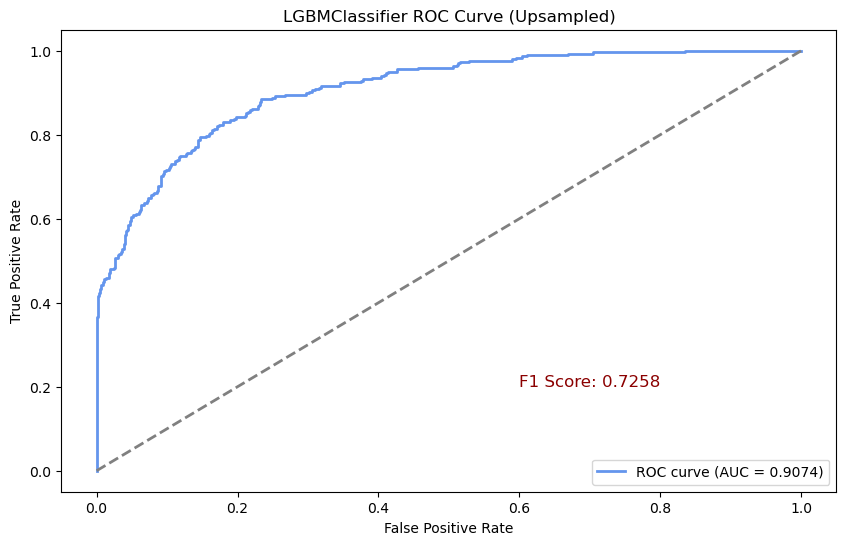

In [118]:
# Function to evaluate model and plot results
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    # Predict the probabilities for the test set
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='cornflowerblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve ({dataset_name})')
    plt.legend(loc='lower right')
    
    # Add F1 score on the plot
    plt.text(0.6, 0.2, f'F1 Score: {f1:.4f}', fontsize=12, color='darkred')
    
    # Show the ROC plot
    plt.show()

# Assuming lgbm is the trained model, X_train_upsampled, y_train_upsampled, X_test, y_test are the data
evaluate_model(lgbm, X_train_upsampled, y_train_upsampled, X_test, y_test, "LGBMClassifier", "Upsampled")


**LGBMClassifier (Upsampled)**

- El AUC (Area Under the Curve) es 0.9263, lo que indica un rendimiento excelente del modelo (un valor cercano a 1 es ideal)
- El F1 Score es 0.7545, representando un buen equilibrio entre precisión y exhaustividad
- La curva ROC (en azul) está muy por encima de la línea diagonal, lo que confirma que el clasificador es mucho mejor que una predicción aleatoria
- El modelo muestra una alta capacidad para distinguir entre clases positivas y negativas, especialmente con una tasa de falsos positivos baja
- Ambas métricas cumplen con lo espero del proyecto. 

En resumen, el LGBMClassifier está funcionando muy bien con esta data upsampled, con métricas que indican un clasificador fiable y efectivo.

### Conclusiones Generales y Próximos Pasos para el Proyecto de Interconnect

**Resumen de Resultados:**

El modelo desarrollado con técnicas de **LGBMClassifier (Upsampled)** ha demostrado ser altamente efectivo para predecir la cancelación de clientes, alcanzando un **AUC-ROC de 0.9263** y un **F1-score de 0.7545**, con un **tiempo de ejecución de 0.1309 segundos**  lo que indica un rendimiento excelente en términos de la capacidad del modelo para distinguir entre clientes que cancelarán y los que no lo harán. Este modelo tiene la capacidad de identificar correctamente a los clientes en riesgo, lo que es esencial para diseñar estrategias de retención.

# Anexos

## Parámetros

**Los resultados de este codigo son los utilizados para entrenar los modelos, lo anexo porque esta demasiado largo y toma mucho tiempo**

```python
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Definir un diccionario con los parámetros a explorar para cada modelo

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1]
}

param_grid_catboost = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Inicializar los modelos
logreg = LogisticRegression(max_iter=1000, random_state=42)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)

# Definir el evaluador de modelos
def evaluate_model_with_search(model, param_grid, X_train, y_train, X_test, y_test, model_name, sampling_method):
    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Utilizar GridSearchCV para optimizar los hiperparámetros
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_
    
    # Evaluar el modelo con el conjunto de prueba
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    
    # Imprimir los resultados
    print(f"{model_name} ({sampling_method})")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"AUC-ROC: {auc:.4f}\n")
    
    return auc, grid_search.best_params_

# Realizar la búsqueda de hiperparámetros para cada modelo

# Logistic Regression with upsampling
evaluate_model_with_search(logreg, param_grid_logreg, X_train, y_train, X_test, y_test, "Logistic Regression", "Upsampled")

# LGBM with upsampling
evaluate_model_with_search(lgbm, param_grid_lgbm, X_train, y_train, X_test, y_test, "LGBM", "Upsampled")

# XGBoost with upsampling
evaluate_model_with_search(xgb, param_grid_xgb, X_train, y_train, X_test, y_test, "XGBoost", "Upsampled")

# CatBoost with upsampling
evaluate_model_with_search(catboost, param_grid_catboost, X_train, y_train, X_test, y_test, "CatBoost", "Upsampled")
```

##  Plan de Trabajo 


**Preguntas:**

1. ¿Es correcta la manera en que transformé los datos a binarios?
2. ¿Es correcta la creación de la columna de 'extra_charges'?




**Pasos a seguir para Resolver la Tarea de Predicción de Churn**

1. **Carga y Preprocesamiento de Datos**
   - Los datos serán cargados y se realizará un preprocesamiento básico: se eliminarán duplicados, se manejarán los valores faltantes y se transformarán las variables categóricas en variables numéricas si es necesario.

2. **División de Datos en Conjuntos de Entrenamiento, Validación y Prueba**
   - Los datos serán divididos en tres subconjuntos: entrenamiento (70%), validación (15%) y prueba (15%), asegurando un balance adecuado entre las clases (se aplicarán técnicas de upsampling o downsampling si es necesario).

3. **Entrenamiento de Modelos**
   - Los modelos básicos como Regresión Logística, LGBMClassifier, XGBClassifier y CatBoostClassifier serán entrenados y ajustados utilizando los datos balanceados, siendo evaluados con métricas como AUC-ROC y precisión.

4. **Evaluación de Modelos**
   - El desempeño de los modelos entrenados será comparado en el conjunto de prueba, evaluándose AUC-ROC, precisión, para determinar el modelo más efectivo.

5. **Informe y Recomendaciones**
   - Un informe será redactado con los resultados obtenidos, comparando el rendimiento de los modelos y recomendando el modelo más efectivo para la predicción de churn, además de sugerir posibles mejoras.

# Informe de Solución 

El proyecto tuvo como objetivo principal predecir la pérdida de clientes (*left (churn)*) para la empresa de telecomunicaciones **Interconnect**, utilizando técnicas de aprendizaje automático. A lo largo del proceso, se abordaron las etapas clásicas de la ciencia de datos: carga y preparación de datos, análisis exploratorio (EDA), ingeniería de características, entrenamiento y evaluación de modelos, y pruebas finales con el mejor modelo seleccionado.

Lo más difícil fue encontrar la manera de alcanzar un F1-score de 0.75. Para obtener los resultados esperados, fue necesario crear nuevas características y modificar la proporción de los conjuntos de datos a 80/10/10, aplicando la técnica de balanceo por **upsampling**. Solo con estos ajustes fue posible entrenar un modelo que superara el umbral deseado en F1. Por otro lado, alcanzar un AUC-ROC superior a 0.85 no representó una gran dificultad. El paso clave fue la creación de nuevas columnas con variables relevantes.

Se probaron combinaciones de partición 60/20/20 y 80/10/10, junto con técnicas de balanceo como **SMOTE**, **upsampling** y **downsampling**, tanto con como sin las nuevas características.

Como resultado, el modelo **LGBMClassifier (Upsampled)** demostró ser altamente efectivo para predecir la cancelación de clientes, alcanzando un AUC-ROC de **0.9263** y un F1-score de **0.7545**, con un tiempo de ejecución de **0.1309 segundos**.

---

**Carga y Preparación de Datos:**  
Se eliminaron duplicados, se imputaron valores ausentes, se trataron valores atípicos, se corrigieron tipos de datos, se crearon nuevas columnas, se estandarizaron variables numéricas y se codificó la columna objetivo `left (churn)` como binaria (0 = se quedó, 1 = se fue).

**Exploratory Data Analysis (EDA):**  
Se identificó un fuerte desbalance en la variable objetivo (~25% left (churn)), se analizaron patrones mensuales en los contratos para detectar picos de abandono, y se calculó una matriz de correlación para destacar relaciones relevantes y eliminar variables redundantes.

**Entrenamiento y Evaluación de Modelos:**  
Los datos se dividieron en entrenamiento, validación y prueba (80/10/10), y se aplicaron técnicas de muestreo para balancear la variable objetivo. Se entrenaron varios modelos: un Dummy Classifier como línea base, y modelos como Logistic Regression, LGBM, XGBoost y CatBoost. La evaluación se realizó principalmente con AUC-ROC y F1-score.

Se seleccionaron los tres modelos con mejor desempeño y se aplicaron al conjunto de prueba. El ganador fue **LGBMClassifier (Upsampled)**. A estos tres modelos también se les midió el tiempo de ejecución.

El modelo cumple con los requisitos básicos para ser considerado adecuado, aunque se recomienda seguir entrenándolo con más datos para mejorar el F1-score y lograr un modelo óptimo.